In [11]:
import os
import pyhf
import pyhf.readxml
from ipywidgets import interact, fixed
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/jshlomi/Downloads/125/')

In [3]:
parsed = pyhf.readxml.parse('driver.xml',os.getcwd())
workspace = pyhf.Workspace(parsed)

In [4]:
pdf = pyhf.Model({'channels': parsed['channels'], 'parameters': parsed['measurements'][0]['config']['parameters']}, poiname = 'SigXsecOverSM')

par_name_dict = {k: v['slice'].start for k,v in pdf.config.par_map.items()}

par_list = par_name_dict.keys()

In [7]:
#load and blind the data

obs_data = []
for obs_channel in workspace.observations:
    obs_data+= workspace.observations[obs_channel]
    
data = obs_data+pdf.config.auxdata
x = np.arange(128)
blinded_x = []
blinded_data = [] 
for channel_i in range(8):
    start_bin = channel_i*16
    end_bin = (channel_i+1)*16
    for bin_idx, bin_i in enumerate( range(start_bin,end_bin) ):
        if bin_idx not in range(3,9):
            blinded_x.append(x[bin_i])
            blinded_data.append(obs_data[bin_i])

In [13]:
#function to get the MC bin counts given some fit parameter modifications
def get_mc_counts(modification_dict={}):
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    
    #modify pars
    for par_name,par_value in modification_dict.items():
    
        pars[par_name_dict[par_name]] = par_value
    
    deltas, factors = pdf._modifications( pars)
    allsum = pyhf.tensorlib.concatenate(deltas + [pyhf.tensorlib.astensor(pdf.nominal_rates)])
    nom_plus_delta = pyhf.tensorlib.sum(allsum,axis=0)
    nom_plus_delta = pyhf.tensorlib.reshape(nom_plus_delta,(1,)+pyhf.tensorlib.shape(nom_plus_delta))
    allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])
    mccounts = pyhf.tensorlib.product(allfac,axis=0)
    
    return mccounts

<IPython.core.display.Javascript object>


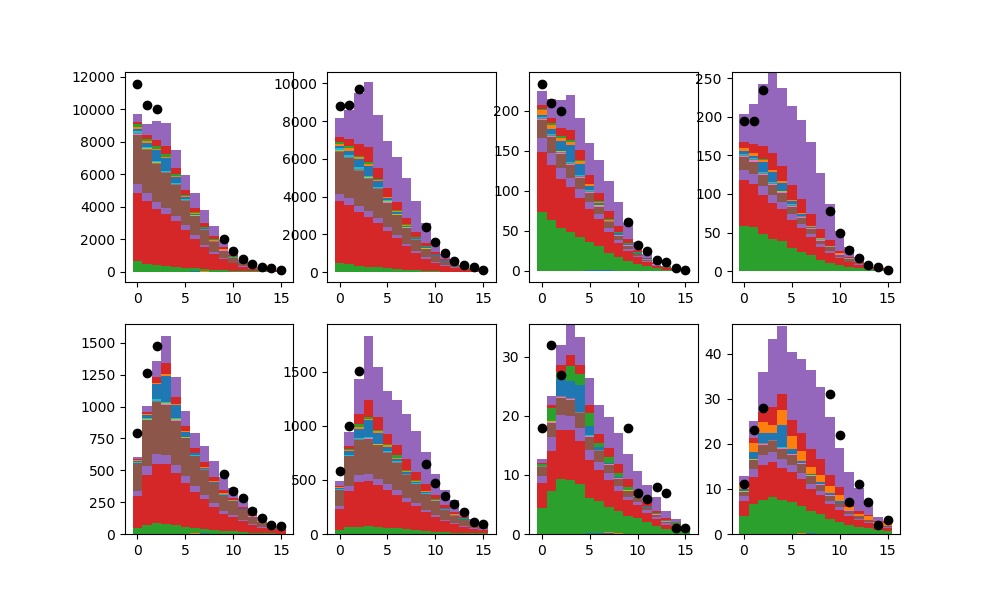

interactive(children=(FloatSlider(value=1.0, description='value', max=3.0, min=-1.0), Dropdown(description='pa…

In [14]:
%matplotlib notebook

fig,ax = plt.subplots(2,4,figsize=(10,6))


n_per_row = 4

animate_objects = {}

#nominal MC
mccounts = get_mc_counts()

for channel_i in range(8):
    row_i = int( channel_i / n_per_row )
    column_i= int( channel_i % n_per_row )

    ax_i = ax[row_i][column_i]
    
    total_mc = np.zeros(16)
    x = np.arange(16)
    slice_start = channel_i*16
    slice_end = (channel_i+1)*16
    
    animate_objects[channel_i] = {}
    
    
    for sample_i in range(15):
        

        mc_for_sample = np.array( mccounts[sample_i][0] )[slice_start:slice_end]

        animate_objects[channel_i][sample_i] = ax_i.bar(x,mc_for_sample,bottom=total_mc,width=1)
        total_mc = total_mc+mc_for_sample
    
    data_slice_start = channel_i*10
    data_slice_end = (channel_i+1)*10
    ax_i.scatter(blinded_x[0:10],
                 blinded_data[data_slice_start:data_slice_end],c='k',zorder=9999)
    
#plt.tight_layout()
#plt.show()
    
def draw_hists(value,paraname,value2,paraname2): #='ATLAS_norm_Wcc'
    
    mod_dict = {paraname:value,paraname2:value2}
    
    mc_counts = get_mc_counts(mod_dict)
    for channel_i in range(8):
        total_mc = np.zeros(16)
        x = np.arange(16)
        slice_start = channel_i*16
        slice_end = (channel_i+1)*16
        for sample_i in range(15):
            mc_for_sample = np.array( mc_counts[sample_i][0] )[slice_start:slice_end]
            
            for bar_i, bar in enumerate( animate_objects[channel_i][sample_i].patches ):
                bar.set_y(total_mc[bar_i])
                bar.set_height(mc_for_sample[bar_i])
                
            total_mc = total_mc+mc_for_sample

    fig.canvas.draw_idle()




interact(draw_hists,value=1.0,paraname=par_list,paraname2=par_list,value2=1.0);
